# Задание

Рассмотреть варианты Байесовского классификатора, представленные в sklearn и найти тот, что будет лучше всего (равномерно) предсказывать все классы по тексту (`./data/financial-news-sentiment.xlsx`).
* Нужно построить распараллеленный препроцессинг на основе Wordnet lematizer.

# Настройки/Импорты

In [92]:
import pandas as pd # для удобной работы с датасетом
import psutil # для просмотра числа потоков на cpu
from pandarallel import pandarallel # для параллельного запуска кода на cpu
from tqdm import tqdm # для отслеживания прогресса

import matplotlib.pyplot as plt # для построения графиков
from wordcloud import WordCloud # для построения изображения с самыми часто встречаемыми словами (помогает в определении дополнительных стоп-слов)

import re # для регулярных выражений
import nltk # для работы с текстом
from nltk.stem import WordNetLemmatizer # лемматизатор (для английского)
from nltk.corpus import stopwords # стоп-слова
from nltk.tokenize import word_tokenize # для токенизации строки

In [97]:
DATA_DIR = "./data/" # путь до папки с данными
RANDOM_STATE = 42 # число для задания случайности
CLEANING_VARS = ["none", "trash", "stop_words", "punctuation", "digits", "all"] # варианты очистки текста
# ADD_STOP_WORDS = ["ca", "n't", "'s"] # дополнительные стоп-слова

In [65]:
# nltk.download('wordnet') # загрузка дополнительных пакетов для nltk
# nltk.download('punkt') # загрузка дополнительных пакетов для nltk

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [29]:
print('Количество доступных потоков: ', psutil.cpu_count(logical=False)) # число доступных топоков

Количество доступных потоков:  4


# Предобработка датасета

In [3]:
dataset = pd.read_excel(DATA_DIR + "financial-news-sentiment.xlsx", usecols=[0,1]) # считывание excel данных (usecols=[0,1] — только первые две колонки)
dataset

,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,Bearish
1,$CCL $RCL - Nomura points to bookings weakness...,Bearish
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",Bearish
3,$ESS: BTIG Research cuts to Neutral https://t....,Bearish
4,$FNKO - Funko slides after Piper Jaffray PT cu...,Bearish
...,...,...
12419,Stocks making the biggest moves midday: TD Ame...,Neutral
12420,Stocks making the biggest moves premarket: Fit...,Neutral
12421,Stocks making the biggest moves premarket: Hom...,Neutral
12422,Stocks making the biggest moves premarket: TD ...,Neutral


## Избавляемся от пропущенных данных

In [4]:
dataset = dataset[dataset["text"].notnull()] # оставляем те строки, у которых столбец "text" имеет значение
dataset = dataset[dataset["label"].notnull()] # оставляем те строки, у которых столбец "label" имеет значение

In [5]:
dataset.shape # размер датасета после удаления пропусков

(11934, 2)

## Избавляемся от выбросов

In [6]:
dataset["label"].value_counts()

label
Neutral                                                                                7732
Bullish                                                                                2397
Bearish                                                                                1788
 answered by @Jess_Shankleman https://t.co/V7NeutralzSgbNnc"                              1
 well                                                                                     1
 in all likelihood                                                                        1
 theyвЂ™re finallyвЂ¦ https://t.co/sVmzdrN4ho"                                            1
Bullish3Bullish.98 points                                                                 1
 breaking 7 consecutive up weeksвЂ¦ https://t.co/kBearish4JSxx56R"                        1
 the #NasdaqFam is setting the pace andвЂ¦ https://t.co/hFU6Y6EUBullisht"                 1
 celebrate 'Drygiving' with these non-boozy alternatives.                 

In [7]:
dataset = dataset[dataset["label"].isin(["Neutral", "Bullish", "Bearish"])] # оставляем те строки, у которых столбец "label" имеет допустимое значение
dataset.shape # размер датасета после удаления выбросов

(11917, 2)

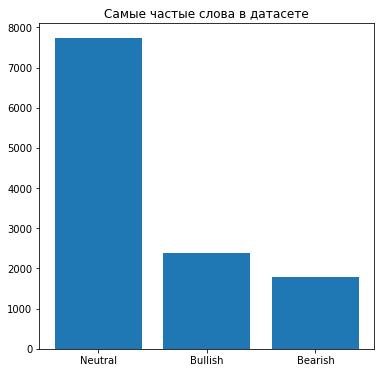

In [56]:
plt.figure(figsize=(6,6)) # задание размера графика
plt.bar(dataset["label"].value_counts().index, dataset["label"].value_counts()) # построение столбатой диаграммы по данным (dataset["label"].value_counts().index — колонки, dataset["label"].value_counts() — их значения)
plt.title("Самые частые слова в датасете") # название графика
plt.show() # вывод графика

##

In [9]:
dataset.reset_index(drop=True, inplace=True) # обновляем индексы, так как они остались от предыдущего варианта датасета (inplace=True и перезаписываем существующий датасет)

## Очистка датасета

In [91]:
stop_words = stopwords.words('english') # список стоп-слов для английского языка
for add_stop in ADD_STOP_WORDS: # идём по дополнительным стоп-словам
    stop_words.append(add_stop) # добавляем стоп-слово
stop_words[:10] # первые 10 стоп-слов для английского языка

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [100]:
pandarallel.initialize(progress_bar=True) # запуск в параллельном режиме (с отображением прогресса выполнения)

def clear_data(df: pd.DataFrame, var, columns=["text"], stop_words=[]) -> pd.DataFrame:
    """
    Универсальная параллельная функция для очистки датасета (лишние пробелы можно не удалять, так как word_tokenize их сам уберёт).\n
    Parameters:
        * df: рассматриваемый датасет
        * var: тип очистки
        * columns: столбцы в датасете, что будут очищаться
        * stop_words: какие стоп-слова использовать\n
    Returns:
        * pd.DataFrame: датасет с очищенными столбцами columns
    """
    # импортируем, так как потоки их перестанут видеть
    import re
    # import pymorphy3
    from nltk.tokenize import word_tokenize
    # from nltk.stem import WordNetLemmatizer # лемматизатор (для английского)


    # morph = pymorphy3.MorphAnalyzer() # объект для лемматизации слов
    lemmatizer = WordNetLemmatizer() # объект для лемматизации слов


    for column in columns:
        df[column] = df[column].parallel_apply(lambda text: text.lower()) # приводим к нижнему регистру

        if var in ["trash", "all"]:
            # df[column] = df[column].parallel_apply(lambda text: re.sub('\[\[\w*d*\|', '', text)) # убираем приписки с id, оставляя имя (они в формате [[id196804815|Ксения])
            # df[column] = df[column].parallel_apply(lambda text: re.sub(']', '', text)) # убираем приписки с id, оставляя имя (они в формате [[id196804815|Ксения])

            # df[column] = df[column].parallel_apply(lambda text: re.sub('@\S*', '', text)) # убираем тегирование (например @Soloviev)

            # df[column] = df[column].parallel_apply(lambda text: re.sub('<.*?>', '', text)) # убираем html элементы

            df[column] = df[column].parallel_apply(lambda text: re.sub("http\S*", ' ', text)) # убираем ссылки (например https://t.co/KN1g4AWFIb)


        if var in ["punctuation", "all"]:
            df[column] = df[column].parallel_apply(lambda text: re.sub(r"[,.…?:;¦/\\!@#$#—+=ツ►๑۞۩•«»“”˜°*`\"'™)(%$&]", '', text)) # удаляем различную пунктуацию
            df[column] = df[column].parallel_apply(lambda text: re.sub("-", ' ', text)) # заменяем тире на пробел


        if var in ["digits", "all"]:
            df[column] = df[column].parallel_apply(lambda text: re.sub('\d', '', text)) # удаляем цифры


        df[column] = df[column].parallel_apply(lambda text: word_tokenize(text)) # разбиваем текст на токены
        # df[column] = df[column].parallel_apply(lambda text: [morph.parse(word)[0].normal_form for word in text]) # приводим слова к нормальной форме (если она у них есть, иначе они остаются без изменения)
        df[column] = df[column].parallel_apply(lambda text: [lemmatizer.lemmatize(word) for word in text]) # лемматизируем слова

        if var in ["stop_words", "all"]:
            df[column] = df[column].parallel_apply(lambda text: [word for word in text if word not in stop_words]) # удаляем стоп-слова

        df[column] = df[column].parallel_apply(lambda text: ' '.join(text)) # собираем токены обратно в строку
        df[column] = df[column].astype('string') # приводим колонку к типу строки (чтобы у записей не было начальных и конечных кавычек)

    return df # возвращаем обработанный датасет

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [101]:
for var in tqdm(CLEANING_VARS): # идём по вариантам обработки
    dataset_cleared = clear_data(dataset.copy(), var, ["text"], stop_words) # проводим очистку датасета
    dataset_cleared.to_csv(DATA_DIR + f"data_{var}.csv", sep=";", index=False) # сохраняем полученный датасет (index=False — без сохранения индексов)

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [00:19<01:35, 19.01s/it]

 33%|███▎      | 2/6 [00:39<01:18, 19.67s/it]

 50%|█████     | 3/6 [00:59<00:59, 19.82s/it]

 67%|██████▋   | 4/6 [01:21<00:41, 20.68s/it]

 83%|████████▎ | 5/6 [01:40<00:20, 20.23s/it]

100%|██████████| 6/6 [02:09<00:00, 21.64s/it]


## Отображение самых частых слов в датасете

Помогает определить дополнительные стоп-слова.

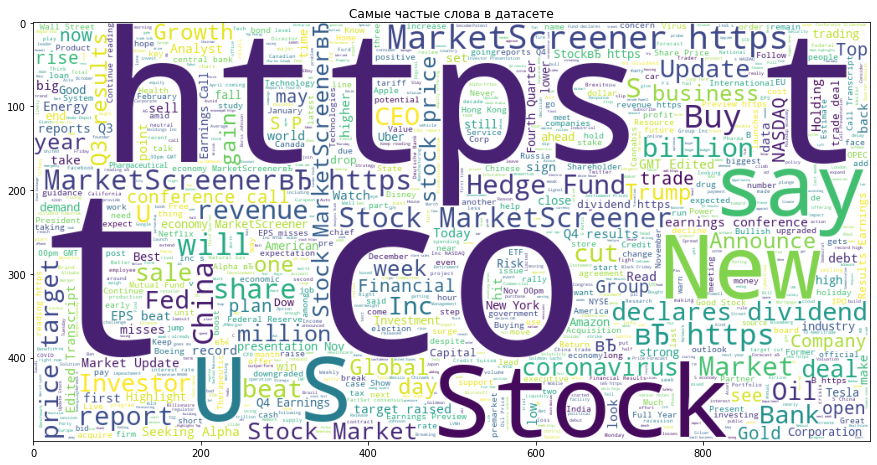

In [45]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=1000, height=500, random_state=RANDOM_STATE) # создание WordCloud объекта
wordcloud.generate(" ".join(dataset["text"])) # отправляем в WordCloud весь текст из датасета

plt.figure(figsize=(15,10)) # задание размера графика
plt.imshow(wordcloud) # отображение картинки
plt.title("Самые частые слова в датасете")
plt.show() # вывод графика

# Обучение моделей